In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [31]:
torch.manual_seed(7)

In [32]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=64, shuffle=True)

C:\Users\ianey\AppData\Local\Temp\ipykernel_7596\2182951934.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
C:\Users\ianey\AppData\Local\Temp\ipykernel_7596\2182951934.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [33]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=64, shuffle=True)

C:\Users\ianey\AppData\Local\Temp\ipykernel_7596\2331197148.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
C:\Users\ianey\AppData\Local\Temp\ipykernel_7596\2331197148.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [34]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    diff = (torch.sum(torch.abs(inl.weight.data - ninc)).item(), torch.sum(torch.abs(oul.weight.data-noul)).item())

    inl.weight.data = ninc
    oul.weight.data = noul

    return diff


In [35]:
model = model.to('cuda')
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

num_epochs = 20  
for epoch in range(num_epochs):
    for b in tqdm(trainloader):
        xt, y = b[0].to('cuda'), b[1].to('cuda')
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])
            while(di[0]+di[1] > .001):
                di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

    for i in range(len(lay)):
        print(f'layer l2 norm for layer {i} = {torch.linalg.norm(lay[i][1].weight, ord=2)}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0].to('cuda'), i[1].to('cuda')
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')


Linear
Linear
Linear
Linear
Linear
Linear


  1%|          | 6/938 [00:00<00:21, 42.75it/s]

100%|██████████| 938/938 [00:03<00:00, 278.36it/s]


Epoch 0/20, Loss: 0.012992316856980324
layer l2 norm for layer 0 = 20.550382614135742
layer l2 norm for layer 1 = 14.450188636779785
layer l2 norm for layer 2 = 9.211395263671875
layer l2 norm for layer 3 = 5.252890586853027
layer l2 norm for layer 4 = 2.489049196243286
layer l2 norm for layer 5 = 2.2772793769836426
test dataset accuracy: 93.22%


100%|██████████| 938/938 [00:03<00:00, 311.33it/s]


Epoch 1/20, Loss: 0.012000980786979198
layer l2 norm for layer 0 = 20.412952423095703
layer l2 norm for layer 1 = 16.299556732177734
layer l2 norm for layer 2 = 10.77902603149414
layer l2 norm for layer 3 = 6.67348575592041
layer l2 norm for layer 4 = 4.257818222045898
layer l2 norm for layer 5 = 3.281071662902832
test dataset accuracy: 93.77%


100%|██████████| 938/938 [00:03<00:00, 305.00it/s]


Epoch 2/20, Loss: 0.01468215137720108
layer l2 norm for layer 0 = 20.912172317504883
layer l2 norm for layer 1 = 17.47650909423828
layer l2 norm for layer 2 = 11.98063850402832
layer l2 norm for layer 3 = 7.607554912567139
layer l2 norm for layer 4 = 5.738134384155273
layer l2 norm for layer 5 = 4.194014072418213
test dataset accuracy: 92.99%


100%|██████████| 938/938 [00:02<00:00, 326.71it/s]


Epoch 3/20, Loss: 0.022397393360733986
layer l2 norm for layer 0 = 22.380992889404297
layer l2 norm for layer 1 = 17.774446487426758
layer l2 norm for layer 2 = 12.991195678710938
layer l2 norm for layer 3 = 9.043404579162598
layer l2 norm for layer 4 = 7.016584873199463
layer l2 norm for layer 5 = 5.315980911254883
test dataset accuracy: 90.59%


100%|██████████| 938/938 [00:02<00:00, 325.08it/s]


Epoch 4/20, Loss: 0.029196327552199364
layer l2 norm for layer 0 = 23.03618621826172
layer l2 norm for layer 1 = 17.952415466308594
layer l2 norm for layer 2 = 13.474788665771484
layer l2 norm for layer 3 = 10.176620483398438
layer l2 norm for layer 4 = 8.38024616241455
layer l2 norm for layer 5 = 6.440901279449463
test dataset accuracy: 82.31%


100%|██████████| 938/938 [00:03<00:00, 310.15it/s]


Epoch 5/20, Loss: 0.01677987538278103
layer l2 norm for layer 0 = 21.416635513305664
layer l2 norm for layer 1 = 18.23726463317871
layer l2 norm for layer 2 = 13.515015602111816
layer l2 norm for layer 3 = 11.207710266113281
layer l2 norm for layer 4 = 9.673736572265625
layer l2 norm for layer 5 = 7.258632183074951
test dataset accuracy: 87.73%


100%|██████████| 938/938 [00:02<00:00, 318.35it/s]


Epoch 6/20, Loss: 0.04759088158607483
layer l2 norm for layer 0 = 22.843122482299805
layer l2 norm for layer 1 = 18.340734481811523
layer l2 norm for layer 2 = 14.380331993103027
layer l2 norm for layer 3 = 12.745013236999512
layer l2 norm for layer 4 = 11.05778980255127
layer l2 norm for layer 5 = 8.416011810302734
test dataset accuracy: 74.4%


100%|██████████| 938/938 [00:03<00:00, 311.83it/s]


Epoch 7/20, Loss: 0.07997184246778488
layer l2 norm for layer 0 = 21.489973068237305
layer l2 norm for layer 1 = 17.383256912231445
layer l2 norm for layer 2 = 14.7383394241333
layer l2 norm for layer 3 = 14.066635131835938
layer l2 norm for layer 4 = 12.400468826293945
layer l2 norm for layer 5 = 9.435715675354004
test dataset accuracy: 27.24%


100%|██████████| 938/938 [00:03<00:00, 289.57it/s]


Epoch 8/20, Loss: 0.07476819306612015
layer l2 norm for layer 0 = 19.671667098999023
layer l2 norm for layer 1 = 15.774994850158691
layer l2 norm for layer 2 = 14.674291610717773
layer l2 norm for layer 3 = 14.839693069458008
layer l2 norm for layer 4 = 13.900996208190918
layer l2 norm for layer 5 = 10.682984352111816
test dataset accuracy: 23.47%


100%|██████████| 938/938 [00:03<00:00, 294.62it/s]


Epoch 9/20, Loss: 0.08205430954694748
layer l2 norm for layer 0 = 18.345149993896484
layer l2 norm for layer 1 = 14.727349281311035
layer l2 norm for layer 2 = 15.025506973266602
layer l2 norm for layer 3 = 15.790756225585938
layer l2 norm for layer 4 = 15.229147911071777
layer l2 norm for layer 5 = 11.767558097839355
test dataset accuracy: 30.33%


100%|██████████| 938/938 [00:03<00:00, 307.52it/s]


Epoch 10/20, Loss: 0.06669796258211136
layer l2 norm for layer 0 = 18.157846450805664
layer l2 norm for layer 1 = 14.397575378417969
layer l2 norm for layer 2 = 15.377676010131836
layer l2 norm for layer 3 = 16.786108016967773
layer l2 norm for layer 4 = 16.463193893432617
layer l2 norm for layer 5 = 12.632248878479004
test dataset accuracy: 36.55%


100%|██████████| 938/938 [00:03<00:00, 295.23it/s]


Epoch 11/20, Loss: 0.09007394313812256
layer l2 norm for layer 0 = 17.152746200561523
layer l2 norm for layer 1 = 14.480801582336426
layer l2 norm for layer 2 = 15.799367904663086
layer l2 norm for layer 3 = 17.66871452331543
layer l2 norm for layer 4 = 17.55469512939453
layer l2 norm for layer 5 = 13.425782203674316
test dataset accuracy: 10.28%


100%|██████████| 938/938 [00:03<00:00, 308.65it/s]


Epoch 12/20, Loss: 0.09039618819952011
layer l2 norm for layer 0 = 15.932243347167969
layer l2 norm for layer 1 = 14.031305313110352
layer l2 norm for layer 2 = 15.88811206817627
layer l2 norm for layer 3 = 18.244070053100586
layer l2 norm for layer 4 = 18.462316513061523
layer l2 norm for layer 5 = 14.123997688293457
test dataset accuracy: 10.32%


100%|██████████| 938/938 [00:02<00:00, 325.73it/s]


Epoch 13/20, Loss: 0.0907387062907219
layer l2 norm for layer 0 = 14.889633178710938
layer l2 norm for layer 1 = 13.562877655029297
layer l2 norm for layer 2 = 15.881322860717773
layer l2 norm for layer 3 = 18.70848846435547
layer l2 norm for layer 4 = 19.17571258544922
layer l2 norm for layer 5 = 14.669829368591309
test dataset accuracy: 10.09%


100%|██████████| 938/938 [00:03<00:00, 306.76it/s]


Epoch 14/20, Loss: 0.08955615013837814
layer l2 norm for layer 0 = 14.16094970703125
layer l2 norm for layer 1 = 13.224128723144531
layer l2 norm for layer 2 = 15.879302024841309
layer l2 norm for layer 3 = 19.065486907958984
layer l2 norm for layer 4 = 19.72834587097168
layer l2 norm for layer 5 = 15.092581748962402
test dataset accuracy: 11.35%


100%|██████████| 938/938 [00:02<00:00, 314.05it/s]


Epoch 15/20, Loss: 0.09042855352163315
layer l2 norm for layer 0 = 13.63596248626709
layer l2 norm for layer 1 = 12.975751876831055
layer l2 norm for layer 2 = 15.878570556640625
layer l2 norm for layer 3 = 19.337848663330078
layer l2 norm for layer 4 = 20.15302085876465
layer l2 norm for layer 5 = 15.417476654052734
test dataset accuracy: 11.35%


100%|██████████| 938/938 [00:02<00:00, 326.71it/s]


Epoch 16/20, Loss: 0.09039916843175888
layer l2 norm for layer 0 = 13.25413990020752
layer l2 norm for layer 1 = 12.79269790649414
layer l2 norm for layer 2 = 15.878571510314941
layer l2 norm for layer 3 = 19.544809341430664
layer l2 norm for layer 4 = 20.477514266967773
layer l2 norm for layer 5 = 15.665728569030762
test dataset accuracy: 10.09%


100%|██████████| 938/938 [00:03<00:00, 294.08it/s]


Epoch 17/20, Loss: 0.09080132097005844
layer l2 norm for layer 0 = 12.97522258758545
layer l2 norm for layer 1 = 12.6571044921875
layer l2 norm for layer 2 = 15.878461837768555
layer l2 norm for layer 3 = 19.701501846313477
layer l2 norm for layer 4 = 20.72426986694336
layer l2 norm for layer 5 = 15.854494094848633
test dataset accuracy: 10.28%


100%|██████████| 938/938 [00:03<00:00, 296.06it/s]


Epoch 18/20, Loss: 0.09049983322620392
layer l2 norm for layer 0 = 12.769373893737793
layer l2 norm for layer 1 = 12.556514739990234
layer l2 norm for layer 2 = 15.878559112548828
layer l2 norm for layer 3 = 19.819854736328125
layer l2 norm for layer 4 = 20.91126251220703
layer l2 norm for layer 5 = 15.997598648071289
test dataset accuracy: 11.35%


100%|██████████| 938/938 [00:03<00:00, 307.68it/s]


Epoch 19/20, Loss: 0.0896553322672844
layer l2 norm for layer 0 = 12.617496490478516
layer l2 norm for layer 1 = 12.481398582458496
layer l2 norm for layer 2 = 15.878480911254883
layer l2 norm for layer 3 = 19.90906524658203
layer l2 norm for layer 4 = 21.05265235900879
layer l2 norm for layer 5 = 16.105745315551758
test dataset accuracy: 11.35%


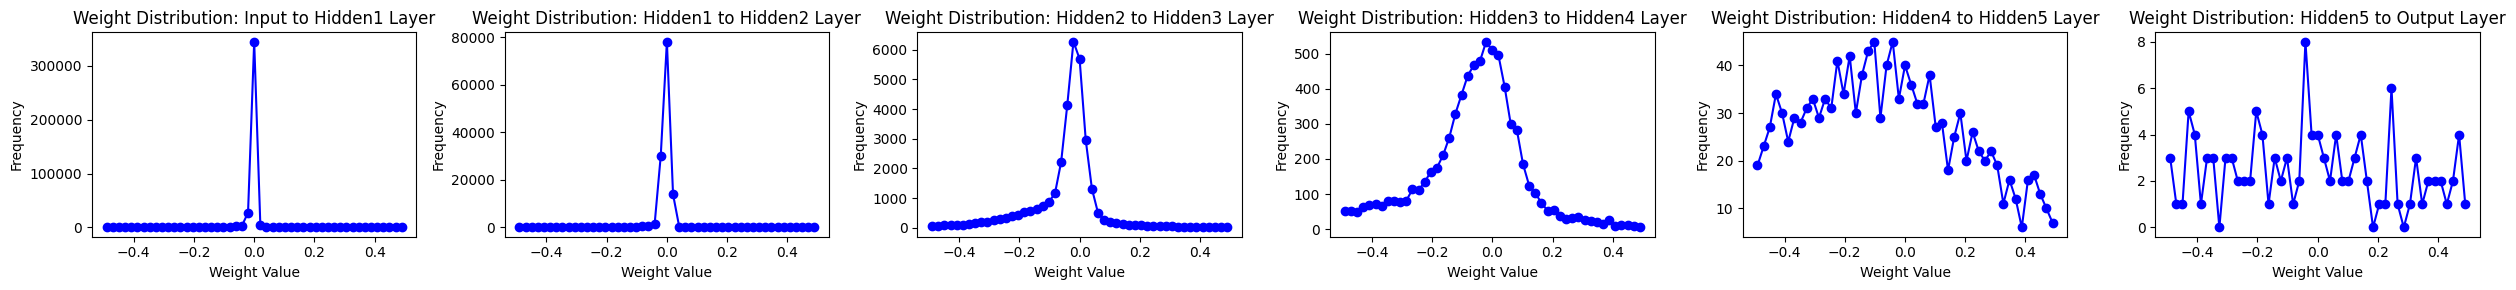

In [36]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
fc3_weights = model.fc3.weight.cpu().detach().numpy().flatten()
fc4_weights = model.fc4.weight.cpu().detach().numpy().flatten()
fc5_weights = model.fc5.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
fc3_hist, fc3_bins = np.histogram(fc3_weights, bins=bins)
fc4_hist, fc4_bins = np.histogram(fc4_weights, bins=bins)
fc5_hist, fc5_bins = np.histogram(fc5_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
fc3_bin_centers = 0.5 * (fc3_bins[:-1] + fc3_bins[1:])
fc4_bin_centers = 0.5 * (fc4_bins[:-1] + fc4_bins[1:])
fc5_bin_centers = 0.5 * (fc5_bins[:-1] + fc5_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 3))

plt.subplot(1, 6, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden1 to Hidden2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 3)
plt.plot(fc3_bin_centers, fc3_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden2 to Hidden3 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 4)
plt.plot(fc4_bin_centers, fc4_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden3 to Hidden4 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 5)
plt.plot(fc5_bin_centers, fc5_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden4 to Hidden5 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 6, 6)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Hidden5 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [37]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.1):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.fc3, threshold=threshold_value)
nonzero_fc4 = count_nonzero_weights_above_threshold(model.fc4, threshold=threshold_value)
nonzero_fc5 = count_nonzero_weights_above_threshold(model.fc5, threshold=threshold_value)
nonzero_out = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1} = {100*nonzero_fc1/(model.fc.weight.data.shape[0]*model.fc.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2} = {100*nonzero_fc2/(model.fc2.weight.data.shape[0]*model.fc2.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3} = {100*nonzero_fc3/(model.fc3.weight.data.shape[0]*model.fc3.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc4} = {100*nonzero_fc4/(model.fc4.weight.data.shape[0]*model.fc4.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc5} = {100*nonzero_fc5/(model.fc5.weight.data.shape[0]*model.fc5.weight.data.shape[1])}%')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_out} = {100*nonzero_out/(model.out.weight.data.shape[0]*model.out.weight.data.shape[1])}%')

Number of non-zero weights greater than 0.01 in layer 1: 60365 = 15.038315130739797%
Number of non-zero weights greater than 0.01 in layer 1: 54390 = 41.49627685546875%
Number of non-zero weights greater than 0.01 in layer 3: 27187 = 82.9681396484375%
Number of non-zero weights greater than 0.01 in layer 1: 7695 = 93.93310546875%
Number of non-zero weights greater than 0.01 in layer 1: 2009 = 98.095703125%
Number of non-zero weights greater than 0.01 in layer 1: 316 = 98.75%


In [38]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.982192697936823, 0.9821926721108951, 0.9821926574446697, 0.98219270060183, 0.9821928932434038, 0.9821929132975582, 0.9821928926573212, 0.9821927124401264, 0.9821927547633686, 0.9821926982501963, 0.9821927963913638, 0.9821927033717347, 0.9821928037028712, 0.9821928122925102, 0.9821928428214938, 0.982192631442179, 0.9821927789817034, 0.9821928321735662, 0.9821928180159171, 0.9821928827095927, 0.9821927607316561, 0.9821928084883658, 0.9821927206217211, 0.9821926928133031, 0.9821926627076875, 0.9821926637866437, 0.9821927654669174, 0.9821926834840836, 0.982192843691398, 0.9821927538864073, 0.9821926397321227, 0.982192712386925, 0.9821928980529044, 0.9821928033200309, 0.9821926949557962, 0.9821928790925375, 0.9821928151218696, 0.9821928427223501, 0.9821928352830797, 0.9821926918764076, 0.9821927969252815, 0.9821927024093833, 0.9821927496499775, 0.9821928835722814, 0.9821927933254186, 0.9821927286596107, 0.9821927091927795, 0.9821928326620403, 0.9821928106988805, 0.9821927891015669, 0.982